In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime

path = 'results/1_1_300000_2g_1_'

# Start and Stop times for Spark Application
with open(path+'/logSpark.txt','r') as f:
    line = f.readline()
    while line:
        if line.startswith('Application started at: '):
            startTime = datetime.strptime(line.strip('Application started at: ').rstrip(),'%H:%M:%S.%f').time()            
        if line.startswith('Application stopped at: '):
            stopTime = datetime.strptime(line.strip('Application stopped at: ').rstrip(),'%H:%M:%S.%f').time()
            break
        line = f.readline()
            

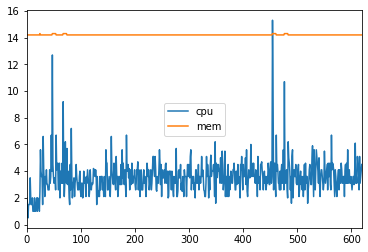

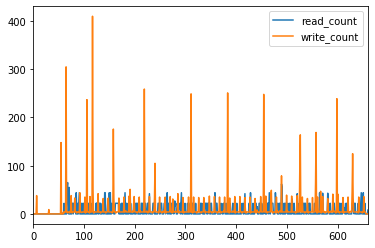

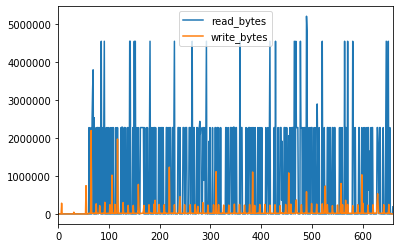

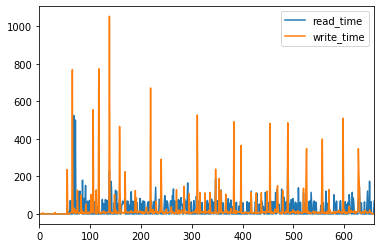

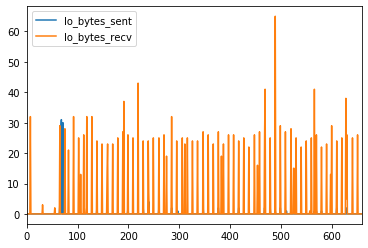

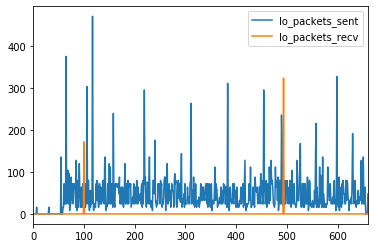

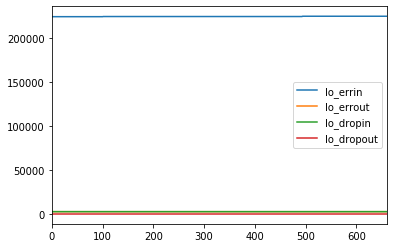

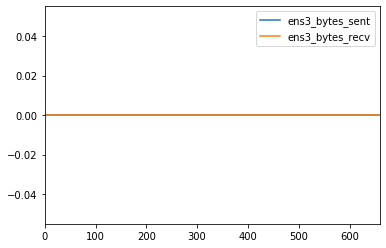

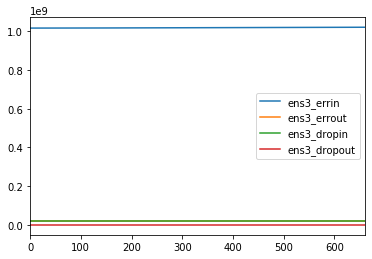

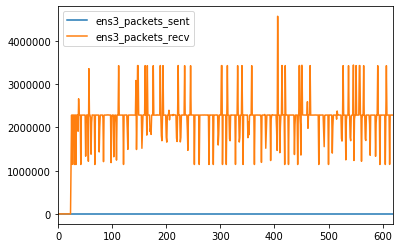

In [2]:
with open(path+'/log_producer.csv','r') as f:
    line = f.readline()
    timestamp = []
    cpu = []
    mem = []
    read_count = []
    write_count = []
    read_bytes = []
    write_bytes = []
    read_time = []
    write_time = []
    bytes_sent = []
    lo_bytes_sent = []
    lo_bytes_recv = []
    lo_packets_sent = []
    lo_packets_recv = []
    lo_errin = []
    lo_errout = []
    lo_dropin = []
    lo_dropout = []
    ens3_bytes_sent = []
    ens3_bytes_recv = []
    ens3_packets_sent = []
    ens3_packets_recv = []
    ens3_errin = []
    ens3_errout = []
    ens3_dropin = []
    ens3_dropout = []
    while line:
        words = line.split(",")
        timestamp.append(datetime.strptime(words[0],'%H:%M:%S.%f').time())
        cpu.append(float(words[1]))
        mem.append(float(words[2]))        
        read_count.append(int(words[3]))         
        write_count.append(int(words[4]))
        read_bytes.append(int(words[5]))
        write_bytes.append(int(words[6]))
        read_time.append(int(words[7]))
        write_time.append(int(words[8]))
        lo_bytes_sent.append(int(words[9]))
        lo_bytes_recv.append(int(words[10]))
        lo_packets_sent.append(int(words[11]))
        lo_packets_recv.append(int(words[12]))
        lo_errin.append(int(words[13]))
        lo_errout.append(int(words[14]))
        lo_dropin.append(int(words[15]))
        lo_dropout.append(int(words[16]))
        ens3_bytes_sent.append(int(words[17]))
        ens3_bytes_recv.append(int(words[18]))
        ens3_packets_sent.append(int(words[19]))
        ens3_packets_recv.append(int(words[20]))
        ens3_errin.append(int(words[21]))
        ens3_errout.append(int(words[22]))
        ens3_dropin.append(int(words[23]))
        ens3_dropout.append(int(words[24]))
        line = f.readline()
    
    for i in range(len(timestamp)):
        if timestamp[i] < startTime:
            start = i+1
        if timestamp[i] > stopTime:
            end = i-1
            break
            
kafkaDF = pd.DataFrame({'time':timestamp[start:end+1],'cpu':cpu[start:end+1], 'mem':mem[start:end+1]})
kafkaDF.plot()
kafkaDF1 = pd.DataFrame({'time':timestamp[1:], 'read_count': [read_count[i]-read_count[i-1] for i in range(1,len(read_count))], 
                         'write_count': [write_count[i]-write_count[i-1] for i in range(1,len(write_count))]})
kafkaDF1.plot()
kafkaDF2 = pd.DataFrame({'time':timestamp[1:], 'read_bytes': [read_bytes[i]-read_bytes[i-1] for i in range(1,len(read_bytes))], 
                         'write_bytes': [write_bytes[i]-write_bytes[i-1] for i in range(1,len(write_bytes))]})
kafkaDF2.plot()
kafkaDF3 = pd.DataFrame({'time':timestamp[1:], 'read_time': [read_time[i]-read_time[i-1] for i in range(1,len(read_time))], 
                         'write_time': [write_time[i]-write_time[i-1] for i in range(1,len(write_time))]})
kafkaDF3.plot()
kafkaDF4 = pd.DataFrame({'time':timestamp[1:], 'lo_bytes_sent': [lo_bytes_sent[i]-lo_bytes_sent[i-1] for i in range(1,len(lo_bytes_sent))], 
                         'lo_bytes_recv': [lo_bytes_recv[i]-lo_bytes_recv[i-1] for i in range(1,len(lo_bytes_recv))]})
kafkaDF4.plot()
kafkaDF5 = pd.DataFrame({'time':timestamp[1:], 
                        'lo_packets_sent':[lo_packets_sent[i]-lo_packets_sent[i-1] for i in range(1,len(lo_packets_sent))], 
                         'lo_packets_recv': [lo_packets_recv[i]-lo_packets_recv[i-1] for i in range(1,len(lo_packets_recv))]})
kafkaDF5.plot()
kafkaDF6 = pd.DataFrame({'time':timestamp, 'lo_errin': lo_errin, 'lo_errout': lo_errout, 'lo_dropin': lo_dropin,
                        'lo_dropout': lo_dropout})
kafkaDF6.plot()
kafkaDF7 = pd.DataFrame({'time':timestamp[1:], 'ens3_bytes_sent': [ens3_bytes_sent[i]-ens3_bytes_sent[i-1] for i in range(1,len(ens3_bytes_sent))], 
                         'ens3_bytes_recv': [ens3_bytes_recv[i]-ens3_bytes_recv[i-1] for i in range(1,len(ens3_bytes_recv))]})
kafkaDF7.plot()
kafkaDF8 = pd.DataFrame({'time':timestamp, 'ens3_errin': ens3_errin, 'ens3_errout': ens3_errout, 'ens3_dropin': ens3_dropin,
                        'ens3_dropout': ens3_dropout})
kafkaDF8.plot()
kafkaDF9 = pd.DataFrame({'time':timestamp[start:end+1], 
                        'ens3_packets_sent':[ens3_packets_sent[i]-ens3_packets_sent[i-1] for i in range(start,end+1)], 
                         'ens3_packets_recv': [ens3_packets_recv[i]-ens3_packets_recv[i-1] for i in range(start,end+1)]})
kafkaDF9.plot()

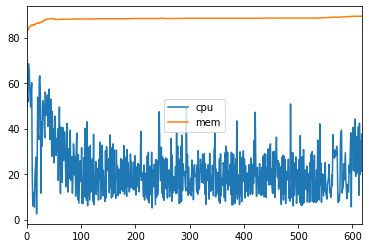

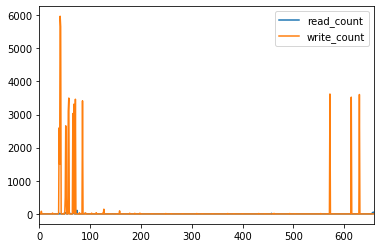

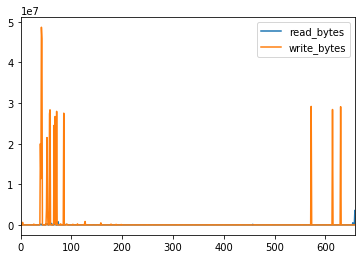

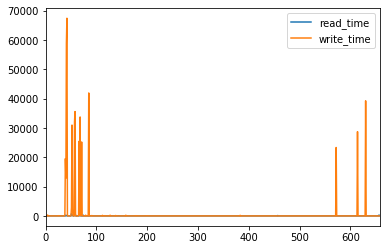

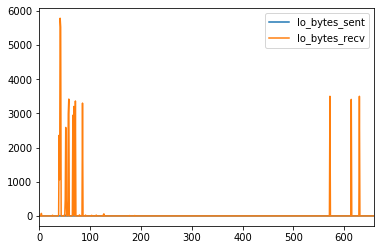

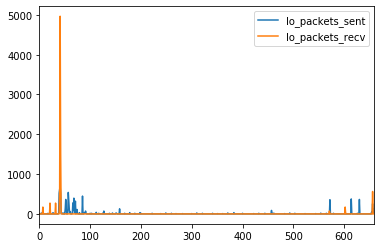

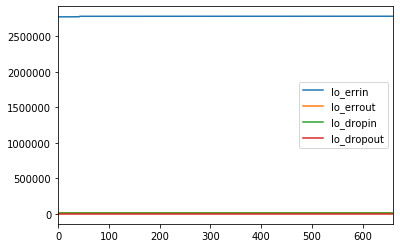

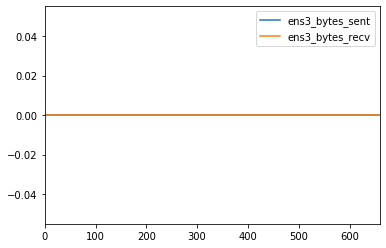

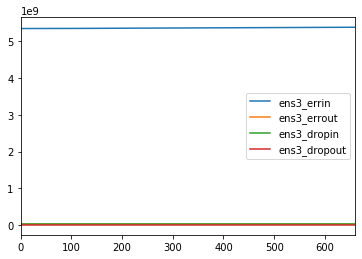

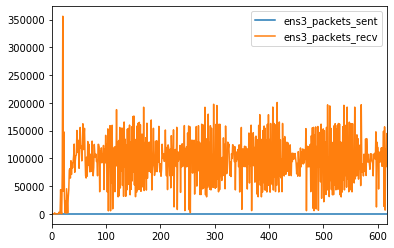

In [3]:
with open(path+'/log_master.csv','r') as f:
    line = f.readline()
    timestamp = []
    cpu = []
    mem = []
    read_count = []
    write_count = []
    read_bytes = []
    write_bytes = []
    read_time = []
    write_time = []
    bytes_sent = []
    lo_bytes_sent = []
    lo_bytes_recv = []
    lo_packets_sent = []
    lo_packets_recv = []
    lo_errin = []
    lo_errout = []
    lo_dropin = []
    lo_dropout = []
    ens3_bytes_sent = []
    ens3_bytes_recv = []
    ens3_packets_sent = []
    ens3_packets_recv = []
    ens3_errin = []
    ens3_errout = []
    ens3_dropin = []
    ens3_dropout = []
    while line:
        words = line.split(",")
        timestamp.append(datetime.strptime(words[0],'%H:%M:%S.%f').time())
        cpu.append(float(words[1]))
        mem.append(float(words[2]))        
        read_count.append(int(words[3]))         
        write_count.append(int(words[4]))
        read_bytes.append(int(words[5]))
        write_bytes.append(int(words[6]))
        read_time.append(int(words[7]))
        write_time.append(int(words[8]))
        lo_bytes_sent.append(int(words[9]))
        lo_bytes_recv.append(int(words[10]))
        lo_packets_sent.append(int(words[11]))
        lo_packets_recv.append(int(words[12]))
        lo_errin.append(int(words[13]))
        lo_errout.append(int(words[14]))
        lo_dropin.append(int(words[15]))
        lo_dropout.append(int(words[16]))
        ens3_bytes_sent.append(int(words[17]))
        ens3_bytes_recv.append(int(words[18]))
        ens3_packets_sent.append(int(words[19]))
        ens3_packets_recv.append(int(words[20]))
        ens3_errin.append(int(words[21]))
        ens3_errout.append(int(words[22]))
        ens3_dropin.append(int(words[23]))
        ens3_dropout.append(int(words[24]))
        line = f.readline()
    
    for i in range(len(timestamp)):
        if timestamp[i] < startTime:
            start = i+1
        if timestamp[i] > stopTime:
            end = i-1
            break
            
kafkaDF = pd.DataFrame({'time':timestamp[start:end+1],'cpu':cpu[start:end+1], 'mem':mem[start:end+1]})
kafkaDF.plot()
kafkaDF1 = pd.DataFrame({'time':timestamp[1:], 'read_count': [read_count[i]-read_count[i-1] for i in range(1,len(read_count))], 
                         'write_count': [write_count[i]-write_count[i-1] for i in range(1,len(write_count))]})
kafkaDF1.plot()
kafkaDF2 = pd.DataFrame({'time':timestamp[1:], 'read_bytes': [read_bytes[i]-read_bytes[i-1] for i in range(1,len(read_bytes))], 
                         'write_bytes': [write_bytes[i]-write_bytes[i-1] for i in range(1,len(write_bytes))]})
kafkaDF2.plot()
kafkaDF3 = pd.DataFrame({'time':timestamp[1:], 'read_time': [read_time[i]-read_time[i-1] for i in range(1,len(read_time))], 
                         'write_time': [write_time[i]-write_time[i-1] for i in range(1,len(write_time))]})
kafkaDF3.plot()
kafkaDF4 = pd.DataFrame({'time':timestamp[1:], 'lo_bytes_sent': [lo_bytes_sent[i]-lo_bytes_sent[i-1] for i in range(1,len(lo_bytes_sent))], 
                         'lo_bytes_recv': [lo_bytes_recv[i]-lo_bytes_recv[i-1] for i in range(1,len(lo_bytes_recv))]})
kafkaDF4.plot()
kafkaDF5 = pd.DataFrame({'time':timestamp[1:], 
                        'lo_packets_sent':[lo_packets_sent[i]-lo_packets_sent[i-1] for i in range(1,len(lo_packets_sent))], 
                         'lo_packets_recv': [lo_packets_recv[i]-lo_packets_recv[i-1] for i in range(1,len(lo_packets_recv))]})
kafkaDF5.plot()
kafkaDF6 = pd.DataFrame({'time':timestamp, 'lo_errin': lo_errin, 'lo_errout': lo_errout, 'lo_dropin': lo_dropin,
                        'lo_dropout': lo_dropout})
kafkaDF6.plot()
kafkaDF7 = pd.DataFrame({'time':timestamp[1:], 'ens3_bytes_sent': [ens3_bytes_sent[i]-ens3_bytes_sent[i-1] for i in range(1,len(ens3_bytes_sent))], 
                         'ens3_bytes_recv': [ens3_bytes_recv[i]-ens3_bytes_recv[i-1] for i in range(1,len(ens3_bytes_recv))]})
kafkaDF7.plot()
kafkaDF8 = pd.DataFrame({'time':timestamp, 'ens3_errin': ens3_errin, 'ens3_errout': ens3_errout, 'ens3_dropin': ens3_dropin,
                        'ens3_dropout': ens3_dropout})
kafkaDF8.plot()
kafkaDF9 = pd.DataFrame({'time':timestamp[start:end+1], 
                        'ens3_packets_sent':[ens3_packets_sent[i]-ens3_packets_sent[i-1] for i in range(start,end+1)], 
                         'ens3_packets_recv': [ens3_packets_recv[i]-ens3_packets_recv[i-1] for i in range(start,end+1)]})
kafkaDF9.plot()

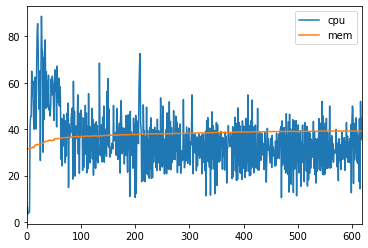

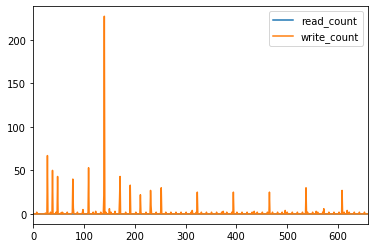

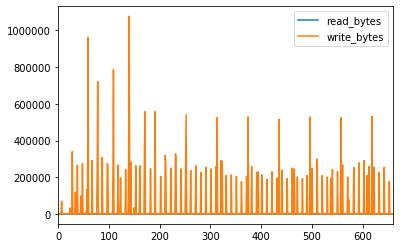

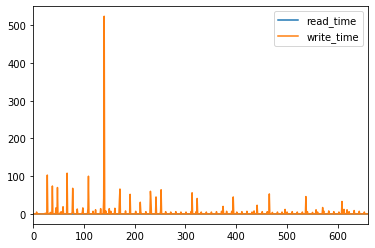

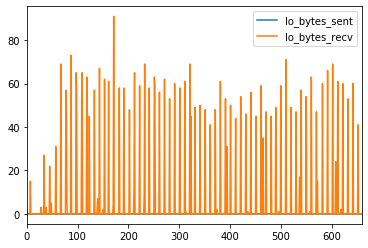

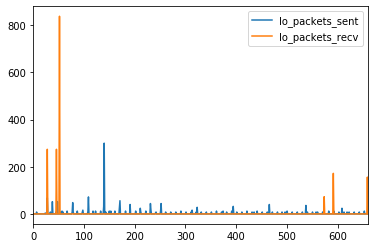

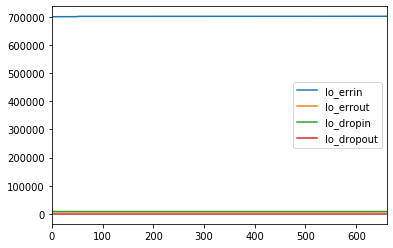

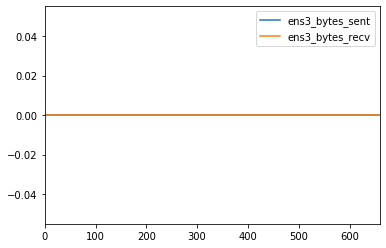

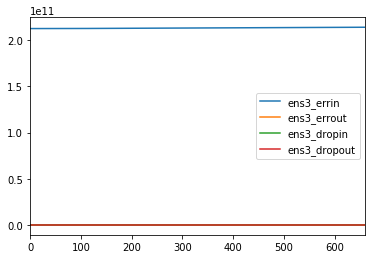

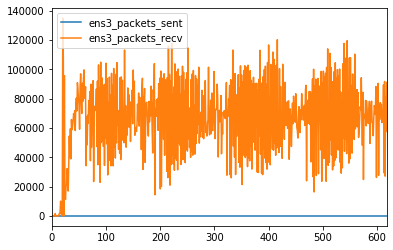

In [4]:
with open(path+'/log_slave1.csv','r') as f:
    line = f.readline()
    timestamp = []
    cpu = []
    mem = []
    read_count = []
    write_count = []
    read_bytes = []
    write_bytes = []
    read_time = []
    write_time = []
    bytes_sent = []
    lo_bytes_sent = []
    lo_bytes_recv = []
    lo_packets_sent = []
    lo_packets_recv = []
    lo_errin = []
    lo_errout = []
    lo_dropin = []
    lo_dropout = []
    ens3_bytes_sent = []
    ens3_bytes_recv = []
    ens3_packets_sent = []
    ens3_packets_recv = []
    ens3_errin = []
    ens3_errout = []
    ens3_dropin = []
    ens3_dropout = []
    while line:
        words = line.split(",")
        timestamp.append(datetime.strptime(words[0],'%H:%M:%S.%f').time())
        cpu.append(float(words[1]))
        mem.append(float(words[2]))        
        read_count.append(int(words[3]))         
        write_count.append(int(words[4]))
        read_bytes.append(int(words[5]))
        write_bytes.append(int(words[6]))
        read_time.append(int(words[7]))
        write_time.append(int(words[8]))
        lo_bytes_sent.append(int(words[9]))
        lo_bytes_recv.append(int(words[10]))
        lo_packets_sent.append(int(words[11]))
        lo_packets_recv.append(int(words[12]))
        lo_errin.append(int(words[13]))
        lo_errout.append(int(words[14]))
        lo_dropin.append(int(words[15]))
        lo_dropout.append(int(words[16]))
        ens3_bytes_sent.append(int(words[17]))
        ens3_bytes_recv.append(int(words[18]))
        ens3_packets_sent.append(int(words[19]))
        ens3_packets_recv.append(int(words[20]))
        ens3_errin.append(int(words[21]))
        ens3_errout.append(int(words[22]))
        ens3_dropin.append(int(words[23]))
        ens3_dropout.append(int(words[24]))
        line = f.readline()
    
    for i in range(len(timestamp)):
        if timestamp[i] < startTime:
            start = i+1
        if timestamp[i] > stopTime:
            end = i-1
            break
            
kafkaDF = pd.DataFrame({'time':timestamp[start:end+1],'cpu':cpu[start:end+1], 'mem':mem[start:end+1]})
kafkaDF.plot()
kafkaDF1 = pd.DataFrame({'time':timestamp[1:], 'read_count': [read_count[i]-read_count[i-1] for i in range(1,len(read_count))], 
                         'write_count': [write_count[i]-write_count[i-1] for i in range(1,len(write_count))]})
kafkaDF1.plot()
kafkaDF2 = pd.DataFrame({'time':timestamp[1:], 'read_bytes': [read_bytes[i]-read_bytes[i-1] for i in range(1,len(read_bytes))], 
                         'write_bytes': [write_bytes[i]-write_bytes[i-1] for i in range(1,len(write_bytes))]})
kafkaDF2.plot()
kafkaDF3 = pd.DataFrame({'time':timestamp[1:], 'read_time': [read_time[i]-read_time[i-1] for i in range(1,len(read_time))], 
                         'write_time': [write_time[i]-write_time[i-1] for i in range(1,len(write_time))]})
kafkaDF3.plot()
kafkaDF4 = pd.DataFrame({'time':timestamp[1:], 'lo_bytes_sent': [lo_bytes_sent[i]-lo_bytes_sent[i-1] for i in range(1,len(lo_bytes_sent))], 
                         'lo_bytes_recv': [lo_bytes_recv[i]-lo_bytes_recv[i-1] for i in range(1,len(lo_bytes_recv))]})
kafkaDF4.plot()
kafkaDF5 = pd.DataFrame({'time':timestamp[1:], 
                        'lo_packets_sent':[lo_packets_sent[i]-lo_packets_sent[i-1] for i in range(1,len(lo_packets_sent))], 
                         'lo_packets_recv': [lo_packets_recv[i]-lo_packets_recv[i-1] for i in range(1,len(lo_packets_recv))]})
kafkaDF5.plot()
kafkaDF6 = pd.DataFrame({'time':timestamp, 'lo_errin': lo_errin, 'lo_errout': lo_errout, 'lo_dropin': lo_dropin,
                        'lo_dropout': lo_dropout})
kafkaDF6.plot()
kafkaDF7 = pd.DataFrame({'time':timestamp[1:], 'ens3_bytes_sent': [ens3_bytes_sent[i]-ens3_bytes_sent[i-1] for i in range(1,len(ens3_bytes_sent))], 
                         'ens3_bytes_recv': [ens3_bytes_recv[i]-ens3_bytes_recv[i-1] for i in range(1,len(ens3_bytes_recv))]})
kafkaDF7.plot()
kafkaDF8 = pd.DataFrame({'time':timestamp, 'ens3_errin': ens3_errin, 'ens3_errout': ens3_errout, 'ens3_dropin': ens3_dropin,
                        'ens3_dropout': ens3_dropout})
kafkaDF8.plot()
kafkaDF9 = pd.DataFrame({'time':timestamp[start:end+1], 
                        'ens3_packets_sent':[ens3_packets_sent[i]-ens3_packets_sent[i-1] for i in range(start,end+1)], 
                         'ens3_packets_recv': [ens3_packets_recv[i]-ens3_packets_recv[i-1] for i in range(start,end+1)]})
kafkaDF9.plot()

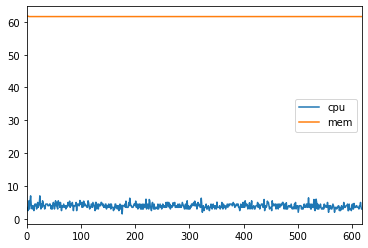

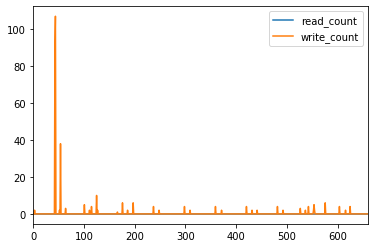

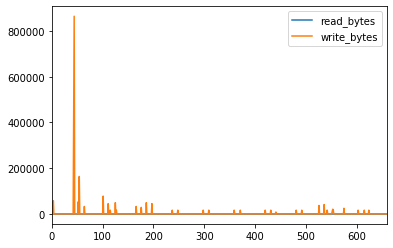

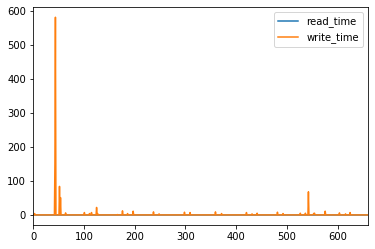

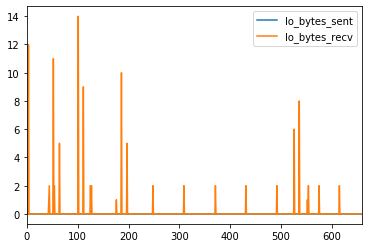

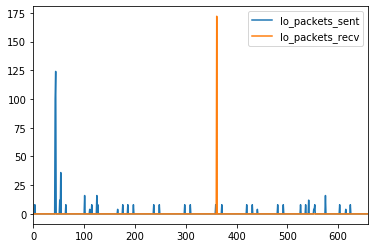

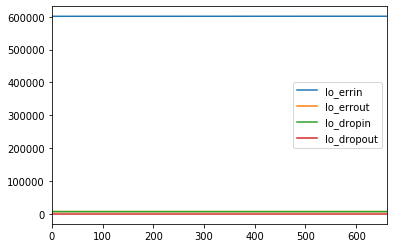

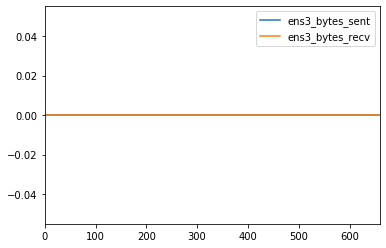

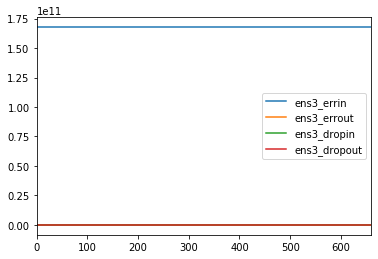

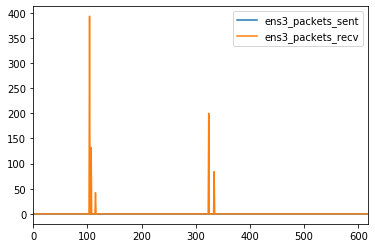

In [5]:
with open(path+'/log_slave2.csv','r') as f:
    line = f.readline()
    timestamp = []
    cpu = []
    mem = []
    read_count = []
    write_count = []
    read_bytes = []
    write_bytes = []
    read_time = []
    write_time = []
    bytes_sent = []
    lo_bytes_sent = []
    lo_bytes_recv = []
    lo_packets_sent = []
    lo_packets_recv = []
    lo_errin = []
    lo_errout = []
    lo_dropin = []
    lo_dropout = []
    ens3_bytes_sent = []
    ens3_bytes_recv = []
    ens3_packets_sent = []
    ens3_packets_recv = []
    ens3_errin = []
    ens3_errout = []
    ens3_dropin = []
    ens3_dropout = []
    while line:
        words = line.split(",")
        timestamp.append(datetime.strptime(words[0],'%H:%M:%S.%f').time())
        cpu.append(float(words[1]))
        mem.append(float(words[2]))        
        read_count.append(int(words[3]))         
        write_count.append(int(words[4]))
        read_bytes.append(int(words[5]))
        write_bytes.append(int(words[6]))
        read_time.append(int(words[7]))
        write_time.append(int(words[8]))
        lo_bytes_sent.append(int(words[9]))
        lo_bytes_recv.append(int(words[10]))
        lo_packets_sent.append(int(words[11]))
        lo_packets_recv.append(int(words[12]))
        lo_errin.append(int(words[13]))
        lo_errout.append(int(words[14]))
        lo_dropin.append(int(words[15]))
        lo_dropout.append(int(words[16]))
        ens3_bytes_sent.append(int(words[17]))
        ens3_bytes_recv.append(int(words[18]))
        ens3_packets_sent.append(int(words[19]))
        ens3_packets_recv.append(int(words[20]))
        ens3_errin.append(int(words[21]))
        ens3_errout.append(int(words[22]))
        ens3_dropin.append(int(words[23]))
        ens3_dropout.append(int(words[24]))
        line = f.readline()
    
    for i in range(len(timestamp)):
        if timestamp[i] < startTime:
            start = i+1
        if timestamp[i] > stopTime:
            end = i-1
            break
            
kafkaDF = pd.DataFrame({'time':timestamp[start:end+1],'cpu':cpu[start:end+1], 'mem':mem[start:end+1]})
kafkaDF.plot()
kafkaDF1 = pd.DataFrame({'time':timestamp[1:], 'read_count': [read_count[i]-read_count[i-1] for i in range(1,len(read_count))], 
                         'write_count': [write_count[i]-write_count[i-1] for i in range(1,len(write_count))]})
kafkaDF1.plot()
kafkaDF2 = pd.DataFrame({'time':timestamp[1:], 'read_bytes': [read_bytes[i]-read_bytes[i-1] for i in range(1,len(read_bytes))], 
                         'write_bytes': [write_bytes[i]-write_bytes[i-1] for i in range(1,len(write_bytes))]})
kafkaDF2.plot()
kafkaDF3 = pd.DataFrame({'time':timestamp[1:], 'read_time': [read_time[i]-read_time[i-1] for i in range(1,len(read_time))], 
                         'write_time': [write_time[i]-write_time[i-1] for i in range(1,len(write_time))]})
kafkaDF3.plot()
kafkaDF4 = pd.DataFrame({'time':timestamp[1:], 'lo_bytes_sent': [lo_bytes_sent[i]-lo_bytes_sent[i-1] for i in range(1,len(lo_bytes_sent))], 
                         'lo_bytes_recv': [lo_bytes_recv[i]-lo_bytes_recv[i-1] for i in range(1,len(lo_bytes_recv))]})
kafkaDF4.plot()
kafkaDF5 = pd.DataFrame({'time':timestamp[1:], 
                        'lo_packets_sent':[lo_packets_sent[i]-lo_packets_sent[i-1] for i in range(1,len(lo_packets_sent))], 
                         'lo_packets_recv': [lo_packets_recv[i]-lo_packets_recv[i-1] for i in range(1,len(lo_packets_recv))]})
kafkaDF5.plot()
kafkaDF6 = pd.DataFrame({'time':timestamp, 'lo_errin': lo_errin, 'lo_errout': lo_errout, 'lo_dropin': lo_dropin,
                        'lo_dropout': lo_dropout})
kafkaDF6.plot()
kafkaDF7 = pd.DataFrame({'time':timestamp[1:], 'ens3_bytes_sent': [ens3_bytes_sent[i]-ens3_bytes_sent[i-1] for i in range(1,len(ens3_bytes_sent))], 
                         'ens3_bytes_recv': [ens3_bytes_recv[i]-ens3_bytes_recv[i-1] for i in range(1,len(ens3_bytes_recv))]})
kafkaDF7.plot()
kafkaDF8 = pd.DataFrame({'time':timestamp, 'ens3_errin': ens3_errin, 'ens3_errout': ens3_errout, 'ens3_dropin': ens3_dropin,
                        'ens3_dropout': ens3_dropout})
kafkaDF8.plot()
kafkaDF9 = pd.DataFrame({'time':timestamp[start:end+1], 
                        'ens3_packets_sent':[ens3_packets_sent[i]-ens3_packets_sent[i-1] for i in range(start,end+1)], 
                         'ens3_packets_recv': [ens3_packets_recv[i]-ens3_packets_recv[i-1] for i in range(start,end+1)]})
kafkaDF9.plot()

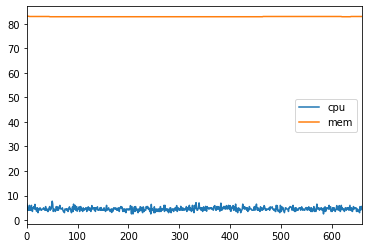

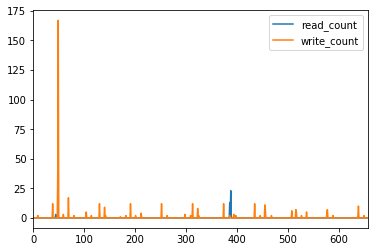

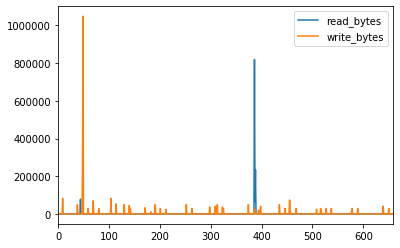

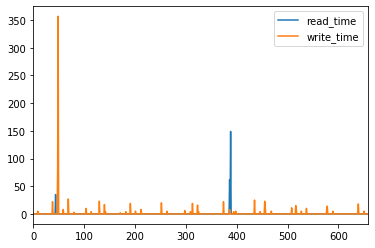

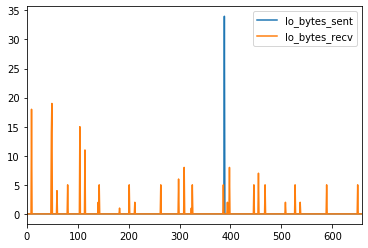

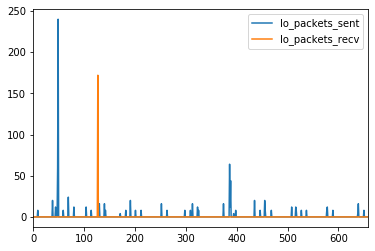

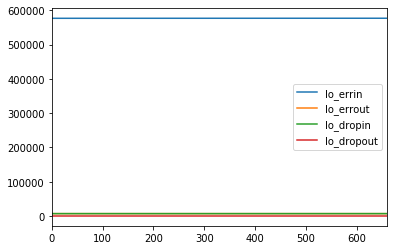

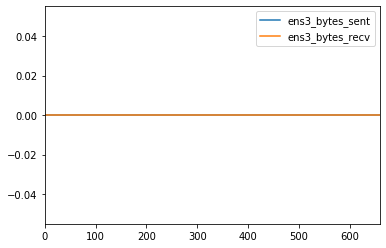

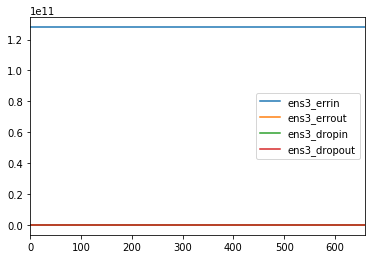

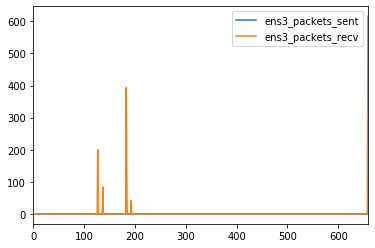

In [6]:
with open(path+'/log_slave3.csv','r') as f:
    line = f.readline()
    timestamp = []
    cpu = []
    mem = []
    read_count = []
    write_count = []
    read_bytes = []
    write_bytes = []
    read_time = []
    write_time = []
    bytes_sent = []
    lo_bytes_sent = []
    lo_bytes_recv = []
    lo_packets_sent = []
    lo_packets_recv = []
    lo_errin = []
    lo_errout = []
    lo_dropin = []
    lo_dropout = []
    ens3_bytes_sent = []
    ens3_bytes_recv = []
    ens3_packets_sent = []
    ens3_packets_recv = []
    ens3_errin = []
    ens3_errout = []
    ens3_dropin = []
    ens3_dropout = []
    while line:
        words = line.split(",")
        timestamp.append(datetime.strptime(words[0],'%H:%M:%S.%f').time())
        cpu.append(float(words[1]))
        mem.append(float(words[2]))        
        read_count.append(int(words[3]))         
        write_count.append(int(words[4]))
        read_bytes.append(int(words[5]))
        write_bytes.append(int(words[6]))
        read_time.append(int(words[7]))
        write_time.append(int(words[8]))
        lo_bytes_sent.append(int(words[9]))
        lo_bytes_recv.append(int(words[10]))
        lo_packets_sent.append(int(words[11]))
        lo_packets_recv.append(int(words[12]))
        lo_errin.append(int(words[13]))
        lo_errout.append(int(words[14]))
        lo_dropin.append(int(words[15]))
        lo_dropout.append(int(words[16]))
        ens3_bytes_sent.append(int(words[17]))
        ens3_bytes_recv.append(int(words[18]))
        ens3_packets_sent.append(int(words[19]))
        ens3_packets_recv.append(int(words[20]))
        ens3_errin.append(int(words[21]))
        ens3_errout.append(int(words[22]))
        ens3_dropin.append(int(words[23]))
        ens3_dropout.append(int(words[24]))
        line = f.readline()
    kafkaDF = pd.DataFrame({'time':timestamp,'cpu':cpu, 'mem':mem})
kafkaDF.plot()
kafkaDF1 = pd.DataFrame({'time':timestamp[1:], 'read_count': [read_count[i]-read_count[i-1] for i in range(1,len(read_count))], 
                         'write_count': [write_count[i]-write_count[i-1] for i in range(1,len(write_count))]})
kafkaDF1.plot()
kafkaDF2 = pd.DataFrame({'time':timestamp[1:], 'read_bytes': [read_bytes[i]-read_bytes[i-1] for i in range(1,len(read_bytes))], 
                         'write_bytes': [write_bytes[i]-write_bytes[i-1] for i in range(1,len(write_bytes))]})
kafkaDF2.plot()
kafkaDF3 = pd.DataFrame({'time':timestamp[1:], 'read_time': [read_time[i]-read_time[i-1] for i in range(1,len(read_time))], 
                         'write_time': [write_time[i]-write_time[i-1] for i in range(1,len(write_time))]})
kafkaDF3.plot()
kafkaDF4 = pd.DataFrame({'time':timestamp[1:], 'lo_bytes_sent': [lo_bytes_sent[i]-lo_bytes_sent[i-1] for i in range(1,len(lo_bytes_sent))], 
                         'lo_bytes_recv': [lo_bytes_recv[i]-lo_bytes_recv[i-1] for i in range(1,len(lo_bytes_recv))]})
kafkaDF4.plot()
kafkaDF5 = pd.DataFrame({'time':timestamp[1:], 
                        'lo_packets_sent':[lo_packets_sent[i]-lo_packets_sent[i-1] for i in range(1,len(lo_packets_sent))], 
                         'lo_packets_recv': [lo_packets_recv[i]-lo_packets_recv[i-1] for i in range(1,len(lo_packets_recv))]})
kafkaDF5.plot()
kafkaDF6 = pd.DataFrame({'time':timestamp, 'lo_errin': lo_errin, 'lo_errout': lo_errout, 'lo_dropin': lo_dropin,
                        'lo_dropout': lo_dropout})
kafkaDF6.plot()
kafkaDF7 = pd.DataFrame({'time':timestamp[1:], 'ens3_bytes_sent': [ens3_bytes_sent[i]-ens3_bytes_sent[i-1] for i in range(1,len(ens3_bytes_sent))], 
                         'ens3_bytes_recv': [ens3_bytes_recv[i]-ens3_bytes_recv[i-1] for i in range(1,len(ens3_bytes_recv))]})
kafkaDF7.plot()
kafkaDF8 = pd.DataFrame({'time':timestamp, 'ens3_errin': ens3_errin, 'ens3_errout': ens3_errout, 'ens3_dropin': ens3_dropin,
                        'ens3_dropout': ens3_dropout})
kafkaDF8.plot()
kafkaDF9 = pd.DataFrame({'time':timestamp[1:], 
                        'ens3_packets_sent':[ens3_packets_sent[i]-ens3_packets_sent[i-1] for i in range(1,len(ens3_packets_sent))], 
                         'ens3_packets_recv': [ens3_packets_recv[i]-ens3_packets_recv[i-1] for i in range(1,len(ens3_packets_recv))]})
kafkaDF9.plot()


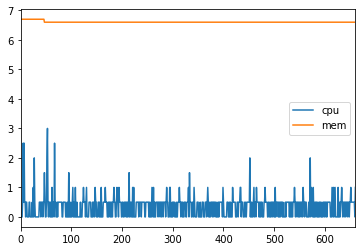

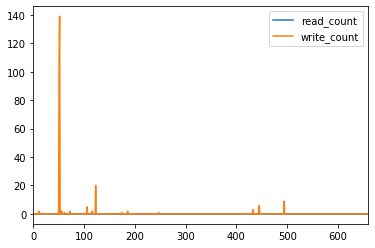

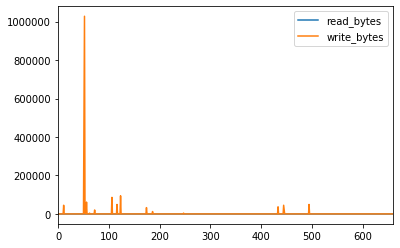

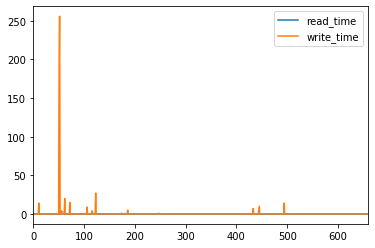

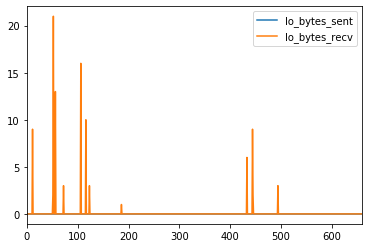

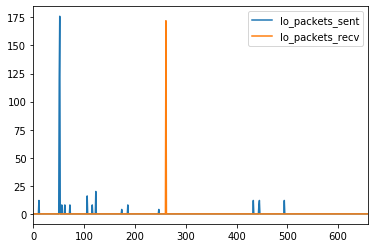

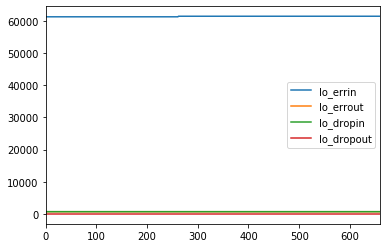

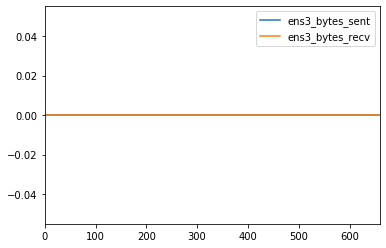

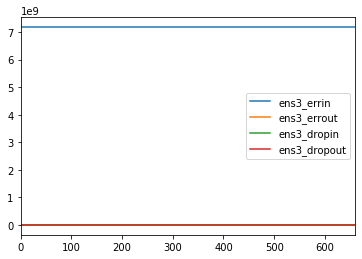

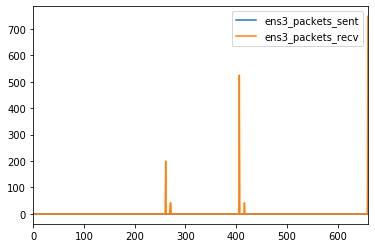

In [7]:
with open(path+'/log_slave4.csv','r') as f:
    line = f.readline()
    timestamp = []
    cpu = []
    mem = []
    read_count = []
    write_count = []
    read_bytes = []
    write_bytes = []
    read_time = []
    write_time = []
    bytes_sent = []
    lo_bytes_sent = []
    lo_bytes_recv = []
    lo_packets_sent = []
    lo_packets_recv = []
    lo_errin = []
    lo_errout = []
    lo_dropin = []
    lo_dropout = []
    ens3_bytes_sent = []
    ens3_bytes_recv = []
    ens3_packets_sent = []
    ens3_packets_recv = []
    ens3_errin = []
    ens3_errout = []
    ens3_dropin = []
    ens3_dropout = []
    while line:
        words = line.split(",")
        timestamp.append(datetime.strptime(words[0],'%H:%M:%S.%f').time())
        cpu.append(float(words[1]))
        mem.append(float(words[2]))        
        read_count.append(int(words[3]))         
        write_count.append(int(words[4]))
        read_bytes.append(int(words[5]))
        write_bytes.append(int(words[6]))
        read_time.append(int(words[7]))
        write_time.append(int(words[8]))
        lo_bytes_sent.append(int(words[9]))
        lo_bytes_recv.append(int(words[10]))
        lo_packets_sent.append(int(words[11]))
        lo_packets_recv.append(int(words[12]))
        lo_errin.append(int(words[13]))
        lo_errout.append(int(words[14]))
        lo_dropin.append(int(words[15]))
        lo_dropout.append(int(words[16]))
        ens3_bytes_sent.append(int(words[17]))
        ens3_bytes_recv.append(int(words[18]))
        ens3_packets_sent.append(int(words[19]))
        ens3_packets_recv.append(int(words[20]))
        ens3_errin.append(int(words[21]))
        ens3_errout.append(int(words[22]))
        ens3_dropin.append(int(words[23]))
        ens3_dropout.append(int(words[24]))
        line = f.readline()
    kafkaDF = pd.DataFrame({'time':timestamp,'cpu':cpu, 'mem':mem})
kafkaDF.plot()
kafkaDF1 = pd.DataFrame({'time':timestamp[1:], 'read_count': [read_count[i]-read_count[i-1] for i in range(1,len(read_count))], 
                         'write_count': [write_count[i]-write_count[i-1] for i in range(1,len(write_count))]})
kafkaDF1.plot()
kafkaDF2 = pd.DataFrame({'time':timestamp[1:], 'read_bytes': [read_bytes[i]-read_bytes[i-1] for i in range(1,len(read_bytes))], 
                         'write_bytes': [write_bytes[i]-write_bytes[i-1] for i in range(1,len(write_bytes))]})
kafkaDF2.plot()
kafkaDF3 = pd.DataFrame({'time':timestamp[1:], 'read_time': [read_time[i]-read_time[i-1] for i in range(1,len(read_time))], 
                         'write_time': [write_time[i]-write_time[i-1] for i in range(1,len(write_time))]})
kafkaDF3.plot()
kafkaDF4 = pd.DataFrame({'time':timestamp[1:], 'lo_bytes_sent': [lo_bytes_sent[i]-lo_bytes_sent[i-1] for i in range(1,len(lo_bytes_sent))], 
                         'lo_bytes_recv': [lo_bytes_recv[i]-lo_bytes_recv[i-1] for i in range(1,len(lo_bytes_recv))]})
kafkaDF4.plot()
kafkaDF5 = pd.DataFrame({'time':timestamp[1:], 
                        'lo_packets_sent':[lo_packets_sent[i]-lo_packets_sent[i-1] for i in range(1,len(lo_packets_sent))], 
                         'lo_packets_recv': [lo_packets_recv[i]-lo_packets_recv[i-1] for i in range(1,len(lo_packets_recv))]})
kafkaDF5.plot()
kafkaDF6 = pd.DataFrame({'time':timestamp, 'lo_errin': lo_errin, 'lo_errout': lo_errout, 'lo_dropin': lo_dropin,
                        'lo_dropout': lo_dropout})
kafkaDF6.plot()
kafkaDF7 = pd.DataFrame({'time':timestamp[1:], 'ens3_bytes_sent': [ens3_bytes_sent[i]-ens3_bytes_sent[i-1] for i in range(1,len(ens3_bytes_sent))], 
                         'ens3_bytes_recv': [ens3_bytes_recv[i]-ens3_bytes_recv[i-1] for i in range(1,len(ens3_bytes_recv))]})
kafkaDF7.plot()
kafkaDF8 = pd.DataFrame({'time':timestamp, 'ens3_errin': ens3_errin, 'ens3_errout': ens3_errout, 'ens3_dropin': ens3_dropin,
                        'ens3_dropout': ens3_dropout})
kafkaDF8.plot()
kafkaDF9 = pd.DataFrame({'time':timestamp[1:], 
                        'ens3_packets_sent':[ens3_packets_sent[i]-ens3_packets_sent[i-1] for i in range(1,len(ens3_packets_sent))], 
                         'ens3_packets_recv': [ens3_packets_recv[i]-ens3_packets_recv[i-1] for i in range(1,len(ens3_packets_recv))]})
kafkaDF9.plot()


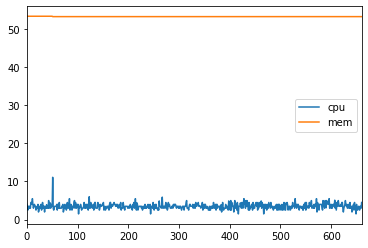

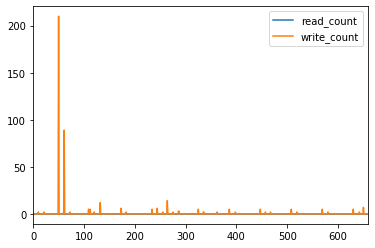

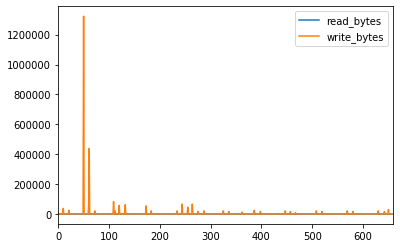

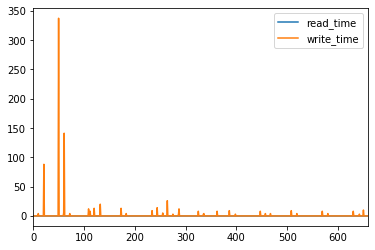

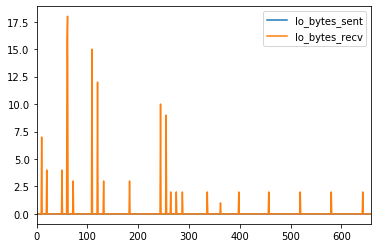

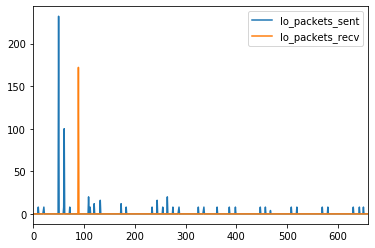

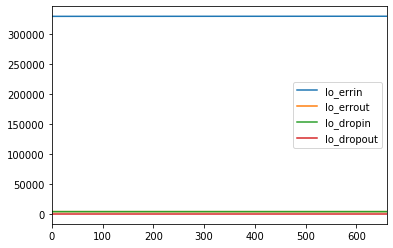

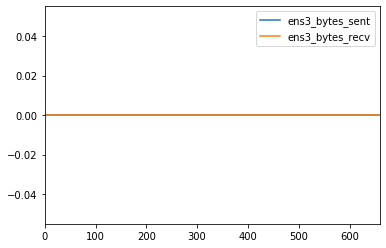

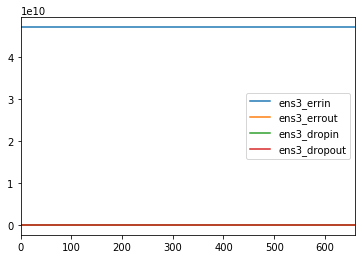

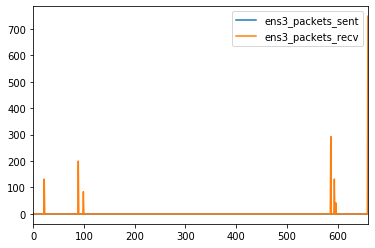

In [8]:
with open(path+'/log_slave5.csv','r') as f:
    line = f.readline()
    timestamp = []
    cpu = []
    mem = []
    read_count = []
    write_count = []
    read_bytes = []
    write_bytes = []
    read_time = []
    write_time = []
    bytes_sent = []
    lo_bytes_sent = []
    lo_bytes_recv = []
    lo_packets_sent = []
    lo_packets_recv = []
    lo_errin = []
    lo_errout = []
    lo_dropin = []
    lo_dropout = []
    ens3_bytes_sent = []
    ens3_bytes_recv = []
    ens3_packets_sent = []
    ens3_packets_recv = []
    ens3_errin = []
    ens3_errout = []
    ens3_dropin = []
    ens3_dropout = []
    while line:
        words = line.split(",")
        timestamp.append(datetime.strptime(words[0],'%H:%M:%S.%f').time())
        cpu.append(float(words[1]))
        mem.append(float(words[2]))        
        read_count.append(int(words[3]))         
        write_count.append(int(words[4]))
        read_bytes.append(int(words[5]))
        write_bytes.append(int(words[6]))
        read_time.append(int(words[7]))
        write_time.append(int(words[8]))
        lo_bytes_sent.append(int(words[9]))
        lo_bytes_recv.append(int(words[10]))
        lo_packets_sent.append(int(words[11]))
        lo_packets_recv.append(int(words[12]))
        lo_errin.append(int(words[13]))
        lo_errout.append(int(words[14]))
        lo_dropin.append(int(words[15]))
        lo_dropout.append(int(words[16]))
        ens3_bytes_sent.append(int(words[17]))
        ens3_bytes_recv.append(int(words[18]))
        ens3_packets_sent.append(int(words[19]))
        ens3_packets_recv.append(int(words[20]))
        ens3_errin.append(int(words[21]))
        ens3_errout.append(int(words[22]))
        ens3_dropin.append(int(words[23]))
        ens3_dropout.append(int(words[24]))
        line = f.readline()
    kafkaDF = pd.DataFrame({'time':timestamp,'cpu':cpu, 'mem':mem})
kafkaDF.plot()
kafkaDF1 = pd.DataFrame({'time':timestamp[1:], 'read_count': [read_count[i]-read_count[i-1] for i in range(1,len(read_count))], 
                         'write_count': [write_count[i]-write_count[i-1] for i in range(1,len(write_count))]})
kafkaDF1.plot()
kafkaDF2 = pd.DataFrame({'time':timestamp[1:], 'read_bytes': [read_bytes[i]-read_bytes[i-1] for i in range(1,len(read_bytes))], 
                         'write_bytes': [write_bytes[i]-write_bytes[i-1] for i in range(1,len(write_bytes))]})
kafkaDF2.plot()
kafkaDF3 = pd.DataFrame({'time':timestamp[1:], 'read_time': [read_time[i]-read_time[i-1] for i in range(1,len(read_time))], 
                         'write_time': [write_time[i]-write_time[i-1] for i in range(1,len(write_time))]})
kafkaDF3.plot()
kafkaDF4 = pd.DataFrame({'time':timestamp[1:], 'lo_bytes_sent': [lo_bytes_sent[i]-lo_bytes_sent[i-1] for i in range(1,len(lo_bytes_sent))], 
                         'lo_bytes_recv': [lo_bytes_recv[i]-lo_bytes_recv[i-1] for i in range(1,len(lo_bytes_recv))]})
kafkaDF4.plot()
kafkaDF5 = pd.DataFrame({'time':timestamp[1:], 
                        'lo_packets_sent':[lo_packets_sent[i]-lo_packets_sent[i-1] for i in range(1,len(lo_packets_sent))], 
                         'lo_packets_recv': [lo_packets_recv[i]-lo_packets_recv[i-1] for i in range(1,len(lo_packets_recv))]})
kafkaDF5.plot()
kafkaDF6 = pd.DataFrame({'time':timestamp, 'lo_errin': lo_errin, 'lo_errout': lo_errout, 'lo_dropin': lo_dropin,
                        'lo_dropout': lo_dropout})
kafkaDF6.plot()
kafkaDF7 = pd.DataFrame({'time':timestamp[1:], 'ens3_bytes_sent': [ens3_bytes_sent[i]-ens3_bytes_sent[i-1] for i in range(1,len(ens3_bytes_sent))], 
                         'ens3_bytes_recv': [ens3_bytes_recv[i]-ens3_bytes_recv[i-1] for i in range(1,len(ens3_bytes_recv))]})
kafkaDF7.plot()
kafkaDF8 = pd.DataFrame({'time':timestamp, 'ens3_errin': ens3_errin, 'ens3_errout': ens3_errout, 'ens3_dropin': ens3_dropin,
                        'ens3_dropout': ens3_dropout})
kafkaDF8.plot()
kafkaDF9 = pd.DataFrame({'time':timestamp[1:], 
                        'ens3_packets_sent':[ens3_packets_sent[i]-ens3_packets_sent[i-1] for i in range(1,len(ens3_packets_sent))], 
                         'ens3_packets_recv': [ens3_packets_recv[i]-ens3_packets_recv[i-1] for i in range(1,len(ens3_packets_recv))]})
kafkaDF9.plot()


In [91]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
import os

path = './results/'
folders = os.listdir(path)
msgsPerFile = 1

results = []
df  = pd.DataFrame()
for folder in folders:
    dct = {} 
    par = folder.split('_')
    dct['nodes'] = int(par[0])
    dct['port'] = int(par[1])
    dct['time'] = int(par[2])
    dct['execMem'] = par[3]
    dct['batchDur'] = int(par[4])
    if par[5]=='':
        dct['version'] = 0
    else:
        dct['version'] = int(par[5])
        
    with open(path+folder+'/logSpark.txt','r') as f:
        line = f.readline()
        while line:
            if line.startswith('Number of messages: '):
                dct['recvMsgs'] = int(line.lstrip('Number of messages: ').strip())
            if line.startswith('Total update time: '):
                dct['updateTime'] = int(line.lstrip('Total update time: ').strip())
            if line.startswith('Size of the data: '):
                dct['totalSize'] = int(line.lstrip('Size of the data: ').strip())
                
            line = f.readline()
            
    with open(path+folder+'/producerResult.txt','r') as f:
        line = f.readline()
        dct['sentMsgs'] = 0
        while line:
            dct['sentMsgs']+=int(line.split(' ')[4])*msgsPerFile
            line = f.readline()
                
    df2 = pd.DataFrame([dct], columns=dct.keys())
    df = pd.concat([df, df2], axis=0)


FileNotFoundError: [Errno 2] No such file or directory: './results/2_2_300000_2g_1_/producerResult.txt'

TypeError: Empty 'DataFrame': no numeric data to plot

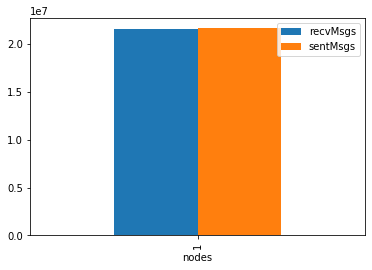

In [92]:
### Do more nodes mean more messages processed?

# 1 port 
df1 = df[(df['port']==1) & (df['execMem']=='2g') & (df['version']==0)].sort_values(by='nodes').filter(items=['nodes','recvMsgs','sentMsgs'])
df1.plot.bar(x='nodes')

# 2 ports
df1 = df[(df['port']==2) & (df['execMem']=='2g') & (df['version']==0)].sort_values(by='nodes').filter(items=['nodes','recvMsgs','sentMsgs'])
df1.plot.bar(x='nodes')

# 3 ports
df1 = df[(df['port']==3) & (df['execMem']=='2g') & (df['version']==0)].sort_values(by='nodes').filter(items=['nodes','recvMsgs','sentMsgs'])
df1.plot.bar(x='nodes')

# 4 ports
df1 = df[(df['port']==4) & (df['execMem']=='2g') & (df['version']==0)].sort_values(by='nodes').filter(items=['nodes','recvMsgs','sentMsgs'])
df1.plot.bar(x='nodes')

# 5 ports
df1 = df[(df['port']==5) & (df['execMem']=='2g') & (df['version']==0)].sort_values(by='nodes').filter(items=['nodes','recvMsgs','sentMsgs'])
df1.plot.bar(x='nodes')

# 6 ports
df1 = df[(df['port']==6) & (df['execMem']=='2g') & (df['version']==0)].sort_values(by='nodes').filter(items=['nodes','recvMsgs','sentMsgs'])
df1.plot.bar(x='nodes')

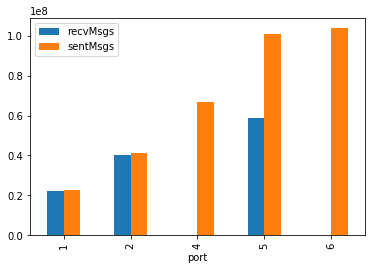

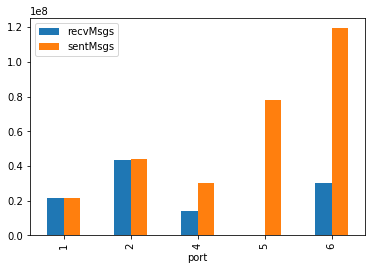

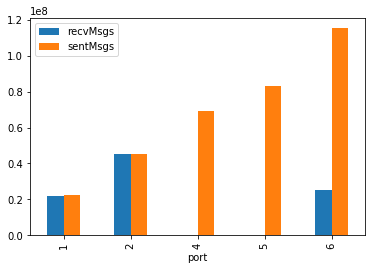

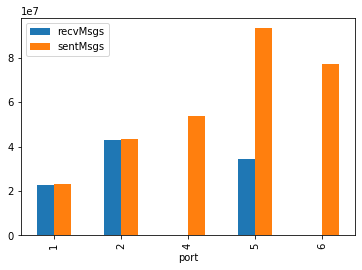

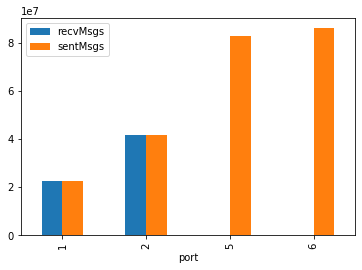

In [12]:
# 6 nodes and 2g
df1 = df[(df['nodes']==6) & (df['execMem']=='2g') & (df['version']==0)].sort_values(by='port').filter(items=['port','recvMsgs','sentMsgs'])
df1.plot.bar(x='port')

# 6 nodes and 4g
df1 = df[(df['nodes']==6) & (df['execMem']=='4g') & (df['version']==0)].sort_values(by='port').filter(items=['port','recvMsgs','sentMsgs'])
df1.plot.bar(x='port')

# 6 nodes and 8g
df1 = df[(df['nodes']==6) & (df['execMem']=='8g') & (df['version']==0)].sort_values(by='port').filter(items=['port','recvMsgs','sentMsgs'])
df1.plot.bar(x='port')

# 6 nodes and 12g
df1 = df[(df['nodes']==6) & (df['execMem']=='12g') & (df['version']==0)].sort_values(by='port').filter(items=['port','recvMsgs','sentMsgs'])
df1.plot.bar(x='port')

# 6 nodes and 12g
df1 = df[(df['nodes']==6) & (df['execMem']=='14g') & (df['version']==0)].sort_values(by='port').filter(items=['port','recvMsgs','sentMsgs'])
df1.plot.bar(x='port')

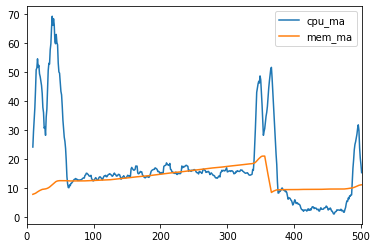

In [41]:
def getMonitorData(path, VM):
    dct = {}
    dct['producer'] = 'log_producer.csv'
    dct['master'] = 'log_master.csv'
    dct['slave1'] = 'log_slave1.csv'
    dct['slave2'] = 'log_slave2.csv'
    dct['slave3'] = 'log_slave3.csv'
    dct['slave4'] = 'log_slave4.csv'
    dct['slave5'] = 'log_slave5.csv'
    dct['slave6'] = 'log_slave6.csv'
    # Start and Stop times for Spark Application
    with open(path+'/logSpark.txt','r') as f:
        line = f.readline()
        while line:
            if line.startswith('Application started at: '):
                startTime = datetime.strptime(line.strip('Application started at: ').rstrip(),'%H:%M:%S.%f').time()            
            if line.startswith('Application stopped at: '):
                stopTime = datetime.strptime(line.strip('Application stopped at: ').rstrip(),'%H:%M:%S.%f').time()
                break
            line = f.readline()
    
    with open(path+'/'+dct[VM],'r') as f:
        line = f.readline()
        timestamp = []
        cpu = []
        mem = []
        read_count = []
        write_count = []
        read_bytes = []
        write_bytes = []
        read_time = []
        write_time = []
        bytes_sent = []
        lo_bytes_sent = []
        lo_bytes_recv = []
        lo_packets_sent = []
        lo_packets_recv = []
        lo_errin = []
        lo_errout = []
        lo_dropin = []
        lo_dropout = []
        ens3_bytes_sent = []
        ens3_bytes_recv = []
        ens3_packets_sent = []
        ens3_packets_recv = []
        ens3_errin = []
        ens3_errout = []
        ens3_dropin = []
        ens3_dropout = []
        while line:
            words = line.split(",")
            timestamp.append(datetime.strptime(words[0],'%H:%M:%S.%f').time())
            cpu.append(float(words[1]))
            mem.append(float(words[2]))        
            read_count.append(int(words[3]))         
            write_count.append(int(words[4]))
            read_bytes.append(int(words[5]))
            write_bytes.append(int(words[6]))
            read_time.append(int(words[7]))
            write_time.append(int(words[8]))
            lo_bytes_sent.append(int(words[9]))
            lo_bytes_recv.append(int(words[10]))
            lo_packets_sent.append(int(words[11]))
            lo_packets_recv.append(int(words[12]))
            lo_errin.append(int(words[13]))
            lo_errout.append(int(words[14]))
            lo_dropin.append(int(words[15]))
            lo_dropout.append(int(words[16]))
            ens3_bytes_sent.append(int(words[17]))
            ens3_bytes_recv.append(int(words[18]))
            ens3_packets_sent.append(int(words[19]))
            ens3_packets_recv.append(int(words[20]))
            ens3_errin.append(int(words[21]))
            ens3_errout.append(int(words[22]))
            ens3_dropin.append(int(words[23]))
            ens3_dropout.append(int(words[24]))
            line = f.readline()

        for i in range(len(timestamp)):
            if timestamp[i] < startTime:
                start = i+1
            if timestamp[i] > stopTime:
                end = i-1
                break
        df = pd.DataFrame({'time':timestamp[start:end+1],'cpu':cpu[start:end+1], 'mem':mem[start:end+1],
                          'read_count': [read_count[i]-read_count[i-1] for i in range(start,end+1)], 
                           'write_count': [write_count[i]-write_count[i-1] for i in range(start, end+1)],
                          'read_bytes':[read_bytes[i]-read_bytes[i-1] for i in range(start, end+1)],
                          'write_bytes':[write_bytes[i]-write_bytes[i-1] for i in range(start, end+1)],
                           'read_time': [read_time[i]-read_time[i-1] for i in range(start, end+1)],
                           'write_time': [write_time[i]-write_time[i-1] for i in range(start, end+1)],
                           'lo_bytes_sent': [lo_bytes_sent[i]-lo_bytes_sent[i-1] for i in range(start, end+1)]
                          })
        
        return df


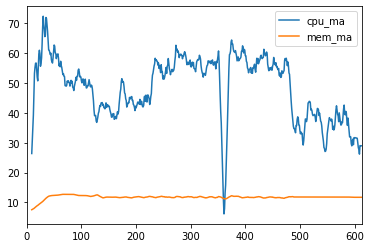

In [87]:
# pick a folder
path = '20000/3_3_300000_2g_1_'

df = getMonitorData(path, 'slave2')

df['cpu_ma'] = df.filter(items=['cpu']).rolling(window=10).mean()
df['mem_ma'] = df.filter(items=['mem']).rolling(window=10).mean()

df.plot(y=['cpu_ma','mem_ma'])